## Imports

In [ ]:
import torchvision
import torch
import torch.nn as nn
from torchvision import transforms
import random
import matplotlib.pyplot as plt
import torch.optim as optim
from google.colab import drive
import sys
import os
sys.path.append('/content/drive/My Drive/Colab Notebooks')
from Gan import Discriminator4
from Gan import Generator4
import torchvision.utils as vutils
import numpy as np

In [ ]:
#!unzip "/content/drive/My Drive/simpson_faces.zip" -d "/content/faces"
!unzip "/content/drive/My Drive/celeba.zip" -d "/content/faces"

In [ ]:
random.seed(999)
torch.manual_seed(999)

## HyperParameters

In [ ]:
BATCH_SIZE = 128     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results
LR = 2e-4           # The Learning Rate
MOMENTUM = 0.5       # Hyperparameter for SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 10      # Total number of training epochs (iterations over dataset)

LOG_FREQUENCY = 100
DEVICE = 'cuda'

In [ ]:
train_transform = transforms.Compose([transforms.Resize(64),      # Resizes short size of the PIL image to 64
                                      transforms.CenterCrop(64),  # Crops a central square patch of the image
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizes tensor with mean and standard deviation
])

In [ ]:
data_train = torchvision.datasets.ImageFolder('./faces', transform=train_transform)
train_loader = torch.utils.data.DataLoader(data_train,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True,
                                          drop_last = True)

Training images

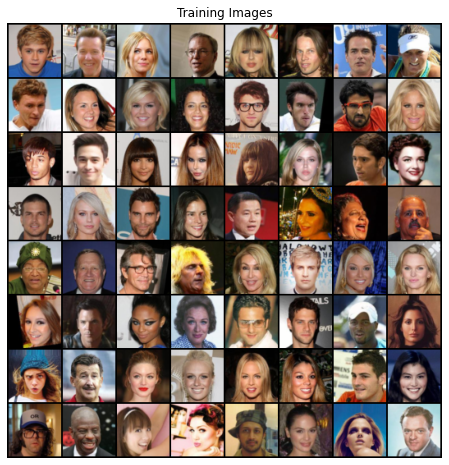

In [ ]:
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(DEVICE)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

Nets + Optimizer

In [ ]:
netD = Discriminator4()
netG = Generator4()

loss_generator = nn.BCELoss()
loss_discriminator = nn.BCELoss() 

#optimizerG = optim.SGD(netG.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
#optimizerD = optim.SGD(netD.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
optimizerG = optim.Adam(netG.parameters(), lr=LR, betas=(MOMENTUM, 0.999))
optimizerD = optim.Adam(netD.parameters(), lr=LR, betas=(MOMENTUM, 0.999))
one = torch.ones(BATCH_SIZE, device=DEVICE)
zero =  torch.zeros(BATCH_SIZE, device=DEVICE)

In [ ]:
netD = torch.load('/content/drive/My Drive/netDFace.pth')
netG = torch.load('/content/drive/My Drive/netGFace.pth')

Training Phase


In [ ]:
step = 0
netD.to(DEVICE)
netG.to(DEVICE)
netD.train(True)
netG.train(True)
img_list = []

for epoch in range(NUM_EPOCHS):
  dl_source_iter = iter(train_loader)

  for indice in range(len(train_loader)):
    real_images, lab  = next(dl_source_iter)
    real_images = real_images.to(DEVICE)
    fixed_noise = torch.randn(BATCH_SIZE, 100, 1, 1, device=DEVICE)

    #Training the discriminator
    netD.zero_grad()
    classes_one = netD(real_images).view(-1)
    lossD1 = loss_discriminator(classes_one, one)

    fake_images = netG(fixed_noise)
    classes_zero = netD(fake_images.detach()).view(-1)
    lossD0 = loss_discriminator(classes_zero, zero)
    lossD = lossD1 + lossD0

    lossD.backward()
    optimizerD.step()

    D_x = classes_one.mean().item()
    D_G_z1 = classes_zero.mean().item()

    #training the generator
    netG.zero_grad()
    classes_zero = netD(fake_images).view(-1)
    lossG = loss_generator(classes_zero, one)
    lossG.backward()
    optimizerG.step()

    D_G_z2 = classes_zero.mean().item()

    if step % LOG_FREQUENCY == 0:
      print(f"Epoch: {epoch + 1}, Step: {step}, LossG: {lossG.item()}, LossD: {lossD.item()}, D_x: {D_x}, D_Gz : {D_G_z1} / {D_G_z2} ")
      noise = torch.randn(int(BATCH_SIZE/4), 100, 1, 1, device=DEVICE)
      with torch.no_grad():
          fake = netG(noise).detach().cpu()
      img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
    
    step += 1

Saving Models



In [ ]:
torch.save(netD, '/content/drive/My Drive/netDFace.pth')
torch.save(netG, '/content/drive/My Drive/netGFace.pth')

Result

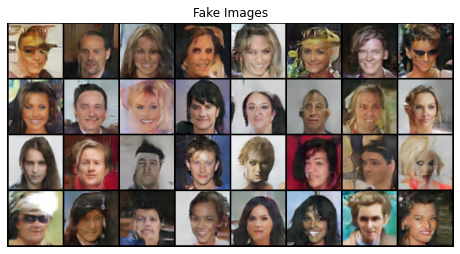

In [ ]:
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

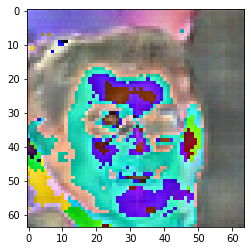

In [ ]:
netG.train(False)
fixed_noise = torch.randn(1, 100, 1, 1, device=DEVICE)
out = netG(fixed_noise).cpu()
trans = transforms.ToPILImage()
plt.imshow(trans(out.squeeze()))
plt.show()

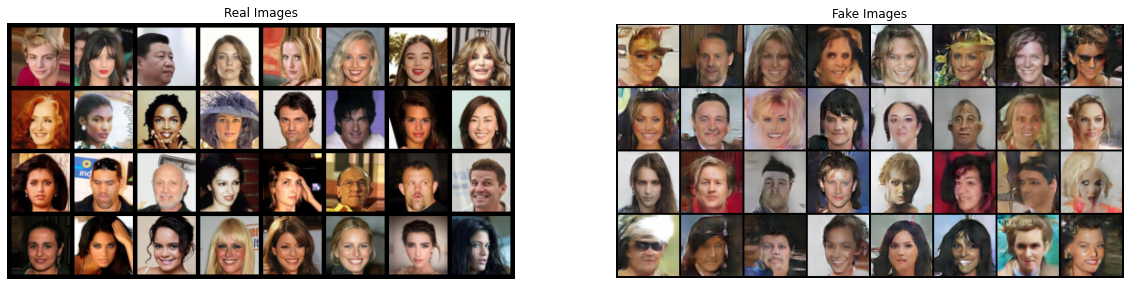

In [ ]:
real_batch = next(iter(train_loader))

# Plot the real images
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(DEVICE)[:32], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()